In [1]:
# importing all the required libraries
import os
import cv2
import glob
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

import torchvision.transforms as transforms
import torchvision.datasets as datasets

import torch.nn as nn
import torch.nn.functional as F
from torch import optim

# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

# Prepare Dataset

In [2]:
#mounting google drive to access the dataset 
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
#loading training and validation datasets, test dataset doesn't have annotations so we will use split traning data into train and test data
train_label_data_path  = '/content/gdrive/MyDrive/DL dataset/gtfine/gtFine_trainvaltest/gtFine/train'
valid_label_data_path  = '/content/gdrive/MyDrive/DL dataset/gtfine/gtFine_trainvaltest/gtFine/val'
train_img_path  = '/content/gdrive/My Drive/DL dataset/leftimg/leftImg8bit/leftImg8bit/train'
valid_img_path  = '/content/gdrive/My Drive/DL dataset/leftimg/leftImg8bit/leftImg8bit/val'

In [4]:
train_labels = sorted(glob.glob(train_label_data_path+"/*/*_labelIds.png"))
valid_labels = sorted(glob.glob(valid_label_data_path+"/*/*_labelIds.png"))
train_inp = sorted(glob.glob(train_img_path+"/*/*.png"))
valid_inp = sorted(glob.glob(valid_img_path+"/*/*.png")) 

In [5]:
from collections import namedtuple

## from labels.py file
# a label and all meta information
Label = namedtuple( 'Label' , [

    'name'        , # The identifier of this label, e.g. 'car', 'person', ... .
                    # We use them to uniquely name a class

    'id'          , # An integer ID that is associated with this label.
                    # The IDs are used to represent the label in ground truth images
                    # An ID of -1 means that this label does not have an ID and thus
                    # is ignored when creating ground truth images (e.g. license plate).
                    # Do not modify these IDs, since exactly these IDs are expected by the
                    # evaluation server.

    'trainId'     , # Feel free to modify these IDs as suitable for your method. Then create
                    # ground truth images with train IDs, using the tools provided in the
                    # 'preparation' folder. However, make sure to validate or submit results
                    # to our evaluation server using the regular IDs above!
                    # For trainIds, multiple labels might have the same ID. Then, these labels
                    # are mapped to the same class in the ground truth images. For the inverse
                    # mapping, we use the label that is defined first in the list below.
                    # For example, mapping all void-type classes to the same ID in training,
                    # might make sense for some approaches.
                    # Max value is 255!

    'category'    , # The name of the category that this label belongs to

    'categoryId'  , # The ID of this category. Used to create ground truth images
                    # on category level.

    'hasInstances', # Whether this label distinguishes between single instances or not

    'ignoreInEval', # Whether pixels having this class as ground truth label are ignored
                    # during evaluations or not

    'color'       , # The color of this label
    ] )


#--------------------------------------------------------------------------------
# A list of all labels
#--------------------------------------------------------------------------------

# Please adapt the train IDs as appropriate for your approach.
# Note that you might want to ignore labels with ID 255 during training.
# Further note that the current train IDs are only a suggestion. You can use whatever you like.
# Make sure to provide your results using the original IDs and not the training IDs.
# Note that many IDs are ignored in evaluation and thus you never need to predict these!

labels = [
    #       name                     id    trainId   category            catId     hasInstances   ignoreInEval   color
    Label(  'unlabeled'            ,  0 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'ego vehicle'          ,  1 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'rectification border' ,  2 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'out of roi'           ,  3 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'static'               ,  4 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'dynamic'              ,  5 ,      255 , 'void'            , 0       , False        , True         , (111, 74,  0) ),
    Label(  'ground'               ,  6 ,      255 , 'void'            , 0       , False        , True         , ( 81,  0, 81) ),
    Label(  'road'                 ,  7 ,        0 , 'flat'            , 1       , False        , False        , (128, 64,128) ),
    Label(  'sidewalk'             ,  8 ,        1 , 'flat'            , 1       , False        , False        , (244, 35,232) ),
    Label(  'parking'              ,  9 ,      255 , 'flat'            , 1       , False        , True         , (250,170,160) ),
    Label(  'rail track'           , 10 ,      255 , 'flat'            , 1       , False        , True         , (230,150,140) ),
    Label(  'building'             , 11 ,        2 , 'construction'    , 2       , False        , False        , ( 70, 70, 70) ),
    Label(  'wall'                 , 12 ,        3 , 'construction'    , 2       , False        , False        , (102,102,156) ),
    Label(  'fence'                , 13 ,        4 , 'construction'    , 2       , False        , False        , (190,153,153) ),
    Label(  'guard rail'           , 14 ,      255 , 'construction'    , 2       , False        , True         , (180,165,180) ),
    Label(  'bridge'               , 15 ,      255 , 'construction'    , 2       , False        , True         , (150,100,100) ),
    Label(  'tunnel'               , 16 ,      255 , 'construction'    , 2       , False        , True         , (150,120, 90) ),
    Label(  'pole'                 , 17 ,        5 , 'object'          , 3       , False        , False        , (153,153,153) ),
    Label(  'polegroup'            , 18 ,      255 , 'object'          , 3       , False        , True         , (153,153,153) ),
    Label(  'traffic light'        , 19 ,        6 , 'object'          , 3       , False        , False        , (250,170, 30) ),
    Label(  'traffic sign'         , 20 ,        7 , 'object'          , 3       , False        , False        , (220,220,  0) ),
    Label(  'vegetation'           , 21 ,        8 , 'nature'          , 4       , False        , False        , (107,142, 35) ),
    Label(  'terrain'              , 22 ,        9 , 'nature'          , 4       , False        , False        , (152,251,152) ),
    Label(  'sky'                  , 23 ,       10 , 'sky'             , 5       , False        , False        , ( 70,130,180) ),
    Label(  'person'               , 24 ,       11 , 'human'           , 6       , True         , False        , (220, 20, 60) ),
    Label(  'rider'                , 25 ,       12 , 'human'           , 6       , True         , False        , (255,  0,  0) ),
    Label(  'car'                  , 26 ,       13 , 'vehicle'         , 7       , True         , False        , (  0,  0,142) ),
    Label(  'truck'                , 27 ,       14 , 'vehicle'         , 7       , True         , False        , (  0,  0, 70) ),
    Label(  'bus'                  , 28 ,       15 , 'vehicle'         , 7       , True         , False        , (  0, 60,100) ),
    Label(  'caravan'              , 29 ,      255 , 'vehicle'         , 7       , True         , True         , (  0,  0, 90) ),
    Label(  'trailer'              , 30 ,      255 , 'vehicle'         , 7       , True         , True         , (  0,  0,110) ),
    Label(  'train'                , 31 ,       16 , 'vehicle'         , 7       , True         , False        , (  0, 80,100) ),
    Label(  'motorcycle'           , 32 ,       17 , 'vehicle'         , 7       , True         , False        , (  0,  0,230) ),
    Label(  'bicycle'              , 33 ,       18 , 'vehicle'         , 7       , True         , False        , (119, 11, 32) ),
    Label(  'license plate'        , -1 ,       -1 , 'vehicle'         , 7       , False        , True         , (  0,  0,142) ),
]

In [6]:
# labels that will be used has ignoreinEval == False
labels_used = []
ids = []
for i in range(len(labels)):
  # if labels[i].name == 'unlabeled':
  #   labels_used.append(labels[i])
  if(labels[i].ignoreInEval == False):
    labels_used.append(labels[i])
    ids.append(labels[i].id)
print("number of labels used = " + format(len(labels_used )))

number of labels used = 19


In [7]:
label_in = cv2.imread(train_labels[0])[:,:,0]#visualize a sample label

In [8]:
#create a dictionary with label_id as key & train_id as value
label_dic = {}
for i in range(len(labels)-1):
  label_dic[labels[i].id] = labels[i].trainId

In [9]:
#function to convert labelids to trainids
def createtrainID(label_in,label_dic):
  mask = np.zeros((label_in.shape[0],label_in.shape[1]))
  l_un = np.unique(label_in)
  for i in range(len(l_un)):
    mask[label_in==l_un[i]] = label_dic[l_un[i]] 
  return mask

In [10]:
#function to visualize the labels
def visual_label(mask,labels_used,plot = False):
  label_img = np.zeros((mask.shape[0],mask.shape[1],3))
  r = np.zeros((mask.shape[0],mask.shape[1]))
  g = np.zeros((mask.shape[0],mask.shape[1]))
  b = np.zeros((mask.shape[0],mask.shape[1]))
  l_un = np.unique(mask)
  for i in range(len(l_un)):
    if l_un[i]<19:
      r[mask==int(l_un[i])] = labels_used[int(l_un[i])].color[0]
      g[mask==int(l_un[i])] = labels_used[int(l_un[i])].color[1]
      b[mask==int(l_un[i])] = labels_used[int(l_un[i])].color[2]
  
  label_img[:,:,0] = r/255
  label_img[:,:,1] = g/255
  label_img[:,:,2] = b/255

  if plot:
    plt.imshow(label_img)
  return label_img

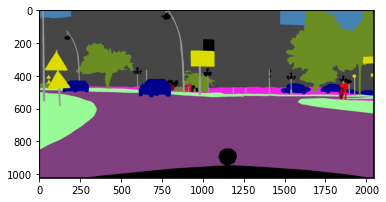

In [11]:
label_img = visual_label(createtrainID(label_in,label_dic),labels_used,plot = True)

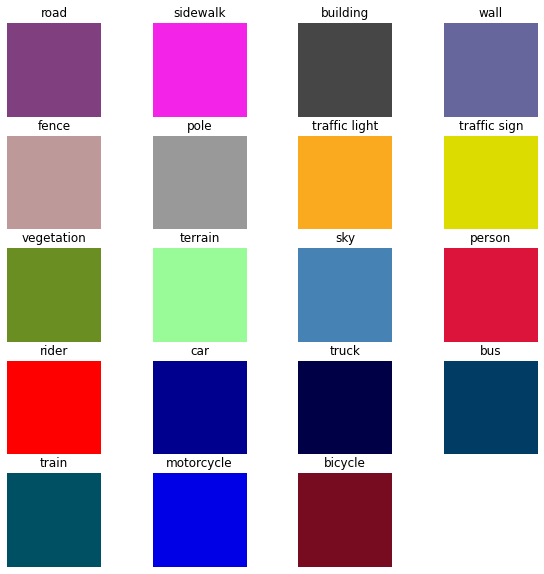

In [12]:
#description of different colors
fig = plt.figure(figsize = (10,10))

for i in range(len(labels_used)):
    temp = np.zeros((5,5,3))
    temp[:,:,0] = labels_used[i].color[0]/255
    temp[:,:,1] = labels_used[i].color[1]/255
    temp[:,:,2] = labels_used[i].color[2]/255
    ax = fig.add_subplot(5, 4, i+1)
    ax.imshow(temp)
    ax.set_title(labels_used[i].name)
    ax.axis('off')

In [13]:
#function to generate images for training, validation and testing
def gen_images(x,s1=96,s2=96):
  _,_,s3 = cv2.imread(x[0]).shape
  img = np.zeros((len(x),s1,s2,s3))
  for i in range(len(x)):
      image= cv2.resize(cv2.imread(x[i]),(s1,s2),interpolation = cv2.INTER_NEAREST)
      image = image/255
      img[i,:,:,:] = image
  return torch.tensor(img).permute(0,3,1,2)



In [14]:
#function to generate images for training, validation and testing
def gen_mask_train(x,label_dic,s1=96,s2=96):
  #s1,s2,_ = cv2.imread(x[0]).shape
  mask = np.zeros((len(x),s1,s2))
  for i in range(len(x)):
      image = createtrainID(cv2.resize(cv2.imread(x[i]),(s1,s2),interpolation = cv2.INTER_NEAREST)[:,:,0],label_dic)
      mask[i,:,:] = image
      mask[mask==255] = 19
  return torch.tensor(mask)

In [15]:
train = []
for x in zip(train_inp,train_labels):
  train.append(x)
valid_dataset =[]
for x in zip(valid_inp,valid_labels):
  valid_dataset.append(x)

n =  len(train)
train_n = int(0.8*n) 
np.random.seed(0)
perm = np.random.permutation(n)
train_dataset = []
test_dataset = []
for i in range(len(perm[0:train_n])):   
  train_dataset.append(train[perm[i]])
for i in range(len(perm[train_n:n])):
  test_dataset.append(train[perm[i]])  

In [16]:
train_loader = torch.utils.data.DataLoader(train_dataset, 
                                           batch_size=16, 
                                           shuffle=True, 
                                           num_workers=0)
valid_loader = torch.utils.data.DataLoader(valid_dataset, 
                                           batch_size=16, 
                                           shuffle=True, 
                                           num_workers=0)
test_loader = torch.utils.data.DataLoader(test_dataset, 
                                           batch_size=16, 
                                           shuffle=True, 
                                           num_workers=0)

In [17]:
print ("Training set size: {}".format(len(train_dataset)))
print ("Validation set size: {}".format(len(valid_dataset)))
print ("Test set size: {}".format(len(test_dataset)))

Training set size: 2380
Validation set size: 500
Test set size: 595


In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [19]:
x,y = iter(train_loader).next()
img = gen_images(x)
img = img.to(device).type(torch.float)
mask = gen_mask_train(y,label_dic)
mask = mask.to(device)

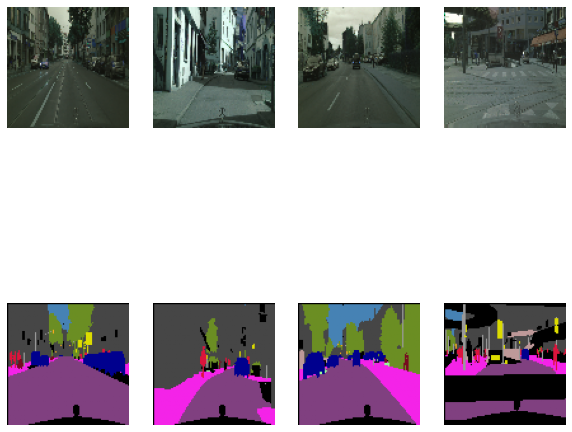

In [21]:
#visualize some of the training images with labels
n_images = 4

fig = plt.figure(figsize = (10,10))

for i in range(n_images*2):
    ax = fig.add_subplot(2, n_images, i+1)
    if i<n_images:
      ax.imshow(img.permute(0,2,3,1)[i,:,:,:].cpu().numpy())
    else:
      ax.imshow(visual_label(mask[int(i%n_images),:,:].cpu().numpy(),labels_used))
    ax.axis('off')

# Model Development (SegNet)

In [22]:
#we will update transforms for final report 
# train_transforms = torch.nn.Sequential(
#                            transforms.RandomRotation(5),
#                            transforms.RandomHorizontalFlip(0.5),
#                        )

In [23]:
#create different operations of the network opearations of the network
'''
First is the single convolution layer.
convulution->batch_norm->relu
'''
class single_conv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(single_conv, self).__init__()
        # Define the layers here
        # Note: for conv, use a padding of (1,1) so that size is maintained
        self.conv = nn.Conv2d(in_ch, out_ch, kernel_size=3,padding = 1)
        self.bn = nn.BatchNorm2d(out_ch,momentum = 0.1)
        self.relu = nn.ReLU()
    def forward(self, x):
        # define forward operation using the layers above
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x
'''
Second is the maxpool with indicies
'''
class down_layer(nn.Module):
    def __init__(self):
        super(down_layer, self).__init__()
        self.down = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True) # use nn.MaxPool2d( )        
    def forward(self, x):
        x1,idx = self.down(x)
        return x1,idx

'''
Third is the unpool layer
'''
class un_pool(nn.Module):
    def __init__(self):
        super(un_pool, self).__init__()       
        self.un_pool = nn.MaxUnpool2d(kernel_size=2, stride=2) # use nn.Upsample() with mode bilinear
        
    
    def forward(self, x, idx,x1):
        #Take the indicies from maxpool layer
        x = self.un_pool(x,idx,output_size = x1.size())
        return x 
'''
Last layer is just convolution layer so we just dust define convoulution
for outlayer
'''
class outconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(outconv, self).__init__()
        # 1 conv layer
        self.conv = nn.Conv2d(in_ch, out_ch, kernel_size=3,padding = 1)

    def forward(self, x):
        # Forward conv layer
        x = self.conv(x)
        return x

In [24]:
# use all above the individual operations to build the network 
class SegNet(nn.Module):
    def __init__(self, n_channels_in, n_classes):
        super(SegNet, self).__init__()
        self.conv1 = single_conv(n_channels_in,64)
        self.conv2 = single_conv(64,64)
        self.down1 = down_layer()
        self.conv3 = single_conv(64,128)
        self.conv4 = single_conv(128,128)
        self.down2 = down_layer()
        self.conv5 = single_conv(128,256)
        self.conv6 = single_conv(256,256)
        self.conv7 = single_conv(256,256)
        self.down3 = down_layer()
        self.conv8 = single_conv(256,512)
        self.conv9 = single_conv(512,512)
        self.conv10 = single_conv(512,512)
        self.down4 = down_layer()
        self.conv11 = single_conv(512,512)
        self.conv12 = single_conv(512,512)
        self.conv13 = single_conv(512,512)
        self.down5 = down_layer()
        self.up1 = un_pool()
        self.conv14 = single_conv(512,512)
        self.conv15 = single_conv(512,512)
        self.conv16 = single_conv(512,512)
        self.up2 = un_pool()
        self.conv17 = single_conv(512,512)
        self.conv18 = single_conv(512,512)
        self.conv19 = single_conv(512,256)
        self.up3 = un_pool()
        self.conv20 = single_conv(256,256)
        self.conv21 = single_conv(256,256)
        self.conv22 = single_conv(256,128)
        self.up4 = un_pool()
        self.conv23 = single_conv(128,128)
        self.conv24 = single_conv(128,64)
        self.up5 = un_pool()
        self.conv25 = single_conv(64,64)
        self.outconv1 = outconv(64,n_classes)

    def forward(self, x):
        # Define forward pass
        x1 = self.conv1(x)
        x2 = self.conv2(x1)
        x3,idx1 = self.down1(x2)
        x4 = self.conv3(x3)
        x5 = self.conv4(x4)
        x6,idx2 = self.down2(x5)
        x7 = self.conv5(x6)
        x8 = self.conv6(x7)
        x9 = self.conv7(x8)
        x10,idx3 = self.down3(x9)
        x11 = self.conv8(x10)
        x12 = self.conv9(x11)
        x13 = self.conv10(x12)
        x14,idx4 = self.down4(x13)
        x15 = self.conv11(x14)
        x16 = self.conv12(x15)
        x17 = self.conv13(x16)
        x18,idx5 = self.down5(x17)
        x19 = self.up1(x18,idx5,x17)
        x20 = self.conv14(x19)
        x21 = self.conv15(x20)
        x22 = self.conv16(x21)
        x23 = self.up2(x22,idx4,x13)
        x24 = self.conv17(x23)
        x25 = self.conv18(x24)
        x26 = self.conv19(x25)
        x27 = self.up3(x26,idx3,x9)
        x28 = self.conv20(x27)
        x29 = self.conv21(x28)
        x30 = self.conv22(x29)
        x31 = self.up4(x30,idx2,x5)
        x32 = self.conv23(x31)
        x33 = self.conv24(x32)
        x34 = self.up4(x33,idx1,x2)
        x35 = self.conv25(x34)
        x = self.outconv1(x35)
        ## Go up back to original dimension
        return x    

In [25]:
net = SegNet(3,20) #one additional class for pixel ignored

In [26]:
#count the number of trainable parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(count_parameters(net))

29454548


In [27]:
NUM_EPOCH = 2 # e.g. 40
BATCH_SIZE = 8 # e.g. 8
LR = 0.001 # e.g. 0.001

In [28]:
optimizer = torch.optim.Adam(
    net.parameters(),
    lr=LR,
)

In [29]:
#initialize the parameters
def initialize_parameters(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight.data, nonlinearity = 'relu')
        nn.init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight.data, gain = nn.init.calculate_gain('relu'))
        nn.init.constant_(m.bias.data, 0)

In [30]:
net.apply(initialize_parameters)

SegNet(
  (conv1): single_conv(
    (conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2): single_conv(
    (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (down1): down_layer(
    (down): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): single_conv(
    (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv4): single_conv(
    (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (down2): dow

In [31]:
 weights = np.zeros((20))
 for (_, y) in tqdm(train_loader):
    y = gen_mask_train(y,label_dic)
    y = y.to(device).long()
    for i in range(20):
      weights[i] += torch.sum((y==i).type(torch.uint8))

100%|██████████| 149/149 [12:09<00:00,  4.90s/it]


In [32]:
weights = np.max(weights)/(weights)
# weights = weights*len(train_dataset)
weights = torch.FloatTensor(weights)

In [33]:
#using cross entropy loss, but the semantic segmentation suffers from class imbalance so we will use weights for each class in the last update for our project
net = net.to(device)
criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device)

# Training SegNet on cityscapes dataset

In [34]:
def mean_iou(y_pred,y,num_classes = 20,last_background = True,smooth = 0.001):
  y_pred = torch.argmax(y_pred,dim=1)
  mean_IoU = []
  if last_background:
    num_classes = num_classes - 1
  for i in range(num_classes):
    class_pred = (y_pred==i).type(torch.uint8)
    class_truth = (y==i).type(torch.uint8)
    union = torch.logical_or(class_pred,class_truth).type(torch.uint8)
    intersection = torch.logical_and(class_pred,class_truth).type(torch.uint8)

    """
    There will be problems when denominator of a class is zero. 
    We used the smoothing to counter the problem.
    """
    IoU = torch.sum(intersection+0.001,dim=(1,2))/torch.sum(union+0.001,dim=(1,2))
    # intersection = torch.sum(intersection, dim =(1,2))
    # union = torch.sum(union, dim =(1,2))
    # if torch.sum((union!=0).type(torch.uint8))!=0:
    #   IoU = intersection[union!=0]/union[union!=0]
    mean_IoU.append(IoU.mean())
  mean_IoU = sum(mean_IoU)/num_classes
  return mean_IoU

In [35]:
# define train epoch
def train(model, iterator, optimizer, criterion, device,label_dic):
    
    epoch_loss = 0
    epoch_IoU = 0
    
    model.train()
    
    for (x, y) in tqdm(iterator):
        x = gen_images(x)
        x = x.to(device).type(torch.float)
        y = gen_mask_train(y,label_dic)
        y = y.to(device).long()
        
        optimizer.zero_grad()
                
        y_pred = model(x)
        
        loss = criterion(y_pred, y)
        
        IoU = mean_iou(y_pred, y)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_IoU += IoU.item()
        
    return epoch_loss / len(iterator), epoch_IoU/len(iterator)

In [36]:
def evaluation(model, iterator, criterion, device,label_dic):
    
    epoch_loss = 0
    epoch_IoU = 0
    
    model.eval()
    
    with torch.no_grad():
      for (x, y) in tqdm(iterator):
          x = gen_images(x)
          x = x.to(device).type(torch.float)
          y = gen_mask_train(y,label_dic)
          y = y.to(device).long()
          
          y_pred = model(x)
          
          loss = criterion(y_pred, y)
          
          IoU = mean_iou(y_pred, y)
          
          epoch_loss += loss.item()
          epoch_IoU += IoU.item()
        
    return epoch_loss / len(iterator), epoch_IoU/len(iterator)

In [37]:
#train for one epoch to fit the data to the CUDA memory, next epochs will be faster
train_loss,train_IoU = train(net, train_loader, optimizer, criterion, device,label_dic)
valid_loss,valid_IoU = evaluation(net, valid_loader, criterion, device,label_dic)

100%|██████████| 32/32 [16:16<00:00, 30.51s/it]


In [38]:
#running on colab pro
!nvidia-smi

Mon Nov 22 05:55:58 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P0    35W / 250W |   2503MiB / 16280MiB |     10%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [39]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [40]:
#training for 40 epochs and save the best model 
best_valid_loss = float('inf')

for epoch in range(40):
    start_time = time.time()
    
    train_loss,train_iou = train(net, train_loader, optimizer, criterion, device,label_dic)
    valid_loss,valid_iou = evaluation(net, valid_loader, criterion, device,label_dic)
        
    end_time = time.time()
        
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)# ...

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(net.state_dict(), 'net.pt')
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train IoU: {train_iou}')
    print(f'\t Val. Loss: {valid_loss:.3f} | Valid IoU: {valid_iou}')

100%|██████████| 32/32 [00:39<00:00,  1.25s/it]


Epoch: 01 | Epoch Time: 4m 13s
	Train Loss: 0.886 | Train IoU: 0.6210171196284711
	 Val. Loss: 0.901 | Valid IoU: 0.5915116891264915


100%|██████████| 32/32 [00:39<00:00,  1.25s/it]


Epoch: 02 | Epoch Time: 4m 12s
	Train Loss: 0.826 | Train IoU: 0.6283871739502721
	 Val. Loss: 0.991 | Valid IoU: 0.586163479834795


100%|██████████| 32/32 [00:40<00:00,  1.25s/it]


Epoch: 03 | Epoch Time: 4m 13s
	Train Loss: 0.810 | Train IoU: 0.6295695120856266
	 Val. Loss: 0.882 | Valid IoU: 0.6010769233107567


100%|██████████| 32/32 [00:40<00:00,  1.25s/it]


Epoch: 04 | Epoch Time: 4m 13s
	Train Loss: 0.749 | Train IoU: 0.6368805010046735
	 Val. Loss: 0.772 | Valid IoU: 0.6080208402127028


100%|██████████| 32/32 [00:39<00:00,  1.24s/it]


Epoch: 05 | Epoch Time: 4m 12s
	Train Loss: 0.735 | Train IoU: 0.6357870801983264
	 Val. Loss: 0.794 | Valid IoU: 0.6095458567142487


100%|██████████| 32/32 [00:39<00:00,  1.24s/it]


Epoch: 06 | Epoch Time: 4m 12s
	Train Loss: 0.711 | Train IoU: 0.6382790219863789
	 Val. Loss: 0.784 | Valid IoU: 0.6121990662068129


100%|██████████| 32/32 [00:39<00:00,  1.24s/it]


Epoch: 07 | Epoch Time: 4m 11s
	Train Loss: 0.709 | Train IoU: 0.6382235608644934
	 Val. Loss: 0.843 | Valid IoU: 0.5772656900808215


100%|██████████| 32/32 [00:39<00:00,  1.24s/it]


Epoch: 08 | Epoch Time: 4m 11s
	Train Loss: 0.707 | Train IoU: 0.6366451778667885
	 Val. Loss: 0.746 | Valid IoU: 0.6058738566935062


100%|██████████| 32/32 [00:39<00:00,  1.24s/it]


Epoch: 09 | Epoch Time: 4m 12s
	Train Loss: 0.684 | Train IoU: 0.6369190364075987
	 Val. Loss: 0.765 | Valid IoU: 0.6015940196812153


100%|██████████| 32/32 [00:39<00:00,  1.25s/it]


Epoch: 10 | Epoch Time: 4m 12s
	Train Loss: 0.688 | Train IoU: 0.6367603260398711
	 Val. Loss: 0.746 | Valid IoU: 0.60814593359828


100%|██████████| 32/32 [00:39<00:00,  1.25s/it]


Epoch: 11 | Epoch Time: 4m 13s
	Train Loss: 0.663 | Train IoU: 0.640712290802258
	 Val. Loss: 0.754 | Valid IoU: 0.6077310089021921


100%|██████████| 32/32 [00:39<00:00,  1.23s/it]


Epoch: 12 | Epoch Time: 4m 9s
	Train Loss: 0.648 | Train IoU: 0.6417672306099194
	 Val. Loss: 0.730 | Valid IoU: 0.6081109121441841


100%|██████████| 32/32 [00:39<00:00,  1.23s/it]


Epoch: 13 | Epoch Time: 4m 10s
	Train Loss: 0.637 | Train IoU: 0.6416846613755962
	 Val. Loss: 0.681 | Valid IoU: 0.6165084894746542


100%|██████████| 32/32 [00:39<00:00,  1.22s/it]


Epoch: 14 | Epoch Time: 4m 9s
	Train Loss: 0.651 | Train IoU: 0.6390045949276661
	 Val. Loss: 0.711 | Valid IoU: 0.6045322772115469


100%|██████████| 32/32 [00:39<00:00,  1.23s/it]


Epoch: 15 | Epoch Time: 4m 9s
	Train Loss: 0.634 | Train IoU: 0.642741442926778
	 Val. Loss: 0.705 | Valid IoU: 0.6046794690191746


100%|██████████| 32/32 [00:39<00:00,  1.24s/it]


Epoch: 16 | Epoch Time: 4m 11s
	Train Loss: 0.624 | Train IoU: 0.6439630057187689
	 Val. Loss: 0.704 | Valid IoU: 0.6130870040506124


100%|██████████| 32/32 [00:39<00:00,  1.23s/it]


Epoch: 17 | Epoch Time: 4m 10s
	Train Loss: 0.610 | Train IoU: 0.6460496975271494
	 Val. Loss: 0.737 | Valid IoU: 0.606079712510109


100%|██████████| 32/32 [00:39<00:00,  1.24s/it]


Epoch: 18 | Epoch Time: 4m 11s
	Train Loss: 0.615 | Train IoU: 0.6455600321692908
	 Val. Loss: 0.739 | Valid IoU: 0.6006584502756596


100%|██████████| 32/32 [00:39<00:00,  1.23s/it]


Epoch: 19 | Epoch Time: 4m 10s
	Train Loss: 0.615 | Train IoU: 0.6458050228605334
	 Val. Loss: 0.702 | Valid IoU: 0.6051357444375753


100%|██████████| 32/32 [00:39<00:00,  1.22s/it]


Epoch: 20 | Epoch Time: 4m 9s
	Train Loss: 0.597 | Train IoU: 0.6473231111596894
	 Val. Loss: 0.694 | Valid IoU: 0.6107539217919111


100%|██████████| 32/32 [00:39<00:00,  1.23s/it]


Epoch: 21 | Epoch Time: 4m 9s
	Train Loss: 0.620 | Train IoU: 0.6412744210070411
	 Val. Loss: 0.764 | Valid IoU: 0.5845576357096434


100%|██████████| 32/32 [00:39<00:00,  1.23s/it]


Epoch: 22 | Epoch Time: 4m 9s
	Train Loss: 0.633 | Train IoU: 0.641088558923478
	 Val. Loss: 0.708 | Valid IoU: 0.6109013836830854


100%|██████████| 32/32 [00:39<00:00,  1.22s/it]


Epoch: 23 | Epoch Time: 4m 9s
	Train Loss: 0.587 | Train IoU: 0.6467321859110122
	 Val. Loss: 0.718 | Valid IoU: 0.5930602084845304


100%|██████████| 32/32 [00:39<00:00,  1.22s/it]


Epoch: 24 | Epoch Time: 4m 10s
	Train Loss: 0.577 | Train IoU: 0.6465982206715833
	 Val. Loss: 0.711 | Valid IoU: 0.6034469474107027


100%|██████████| 32/32 [00:39<00:00,  1.22s/it]


Epoch: 25 | Epoch Time: 4m 7s
	Train Loss: 0.579 | Train IoU: 0.6461830215166079
	 Val. Loss: 0.704 | Valid IoU: 0.5999118909239769


100%|██████████| 32/32 [00:38<00:00,  1.21s/it]


Epoch: 26 | Epoch Time: 4m 6s
	Train Loss: 0.570 | Train IoU: 0.647354728423509
	 Val. Loss: 0.693 | Valid IoU: 0.6072643268853426


100%|██████████| 32/32 [00:39<00:00,  1.23s/it]


Epoch: 27 | Epoch Time: 4m 8s
	Train Loss: 0.570 | Train IoU: 0.6468530101264083
	 Val. Loss: 0.696 | Valid IoU: 0.6252376493066549


100%|██████████| 32/32 [00:39<00:00,  1.22s/it]


Epoch: 28 | Epoch Time: 4m 8s
	Train Loss: 0.542 | Train IoU: 0.650430662920011
	 Val. Loss: 0.698 | Valid IoU: 0.5956300515681505


100%|██████████| 32/32 [00:39<00:00,  1.23s/it]


Epoch: 29 | Epoch Time: 4m 9s
	Train Loss: 0.540 | Train IoU: 0.6501016840838746
	 Val. Loss: 0.694 | Valid IoU: 0.6066636424511671


100%|██████████| 32/32 [00:41<00:00,  1.30s/it]


Epoch: 30 | Epoch Time: 4m 20s
	Train Loss: 0.549 | Train IoU: 0.6487804955284068
	 Val. Loss: 0.700 | Valid IoU: 0.5899728331714869


100%|██████████| 32/32 [00:39<00:00,  1.22s/it]


Epoch: 31 | Epoch Time: 4m 18s
	Train Loss: 0.532 | Train IoU: 0.6491942693723128
	 Val. Loss: 0.705 | Valid IoU: 0.6005963552743196


100%|██████████| 32/32 [00:39<00:00,  1.23s/it]


Epoch: 32 | Epoch Time: 4m 8s
	Train Loss: 0.548 | Train IoU: 0.6449330465105556
	 Val. Loss: 0.749 | Valid IoU: 0.5999853741377592


100%|██████████| 32/32 [00:39<00:00,  1.22s/it]


Epoch: 33 | Epoch Time: 4m 8s
	Train Loss: 0.531 | Train IoU: 0.6509419675641412
	 Val. Loss: 0.707 | Valid IoU: 0.600969698280096


100%|██████████| 32/32 [00:39<00:00,  1.22s/it]


Epoch: 34 | Epoch Time: 4m 8s
	Train Loss: 0.501 | Train IoU: 0.6532512595189498
	 Val. Loss: 0.758 | Valid IoU: 0.5840938948094845


100%|██████████| 32/32 [00:39<00:00,  1.23s/it]


Epoch: 35 | Epoch Time: 4m 8s
	Train Loss: 0.517 | Train IoU: 0.6510226446510161
	 Val. Loss: 0.699 | Valid IoU: 0.5842705219984055


100%|██████████| 32/32 [00:39<00:00,  1.22s/it]


Epoch: 36 | Epoch Time: 4m 7s
	Train Loss: 0.496 | Train IoU: 0.654675369694729
	 Val. Loss: 0.716 | Valid IoU: 0.5934869311749935


100%|██████████| 32/32 [00:38<00:00,  1.21s/it]


Epoch: 37 | Epoch Time: 4m 7s
	Train Loss: 0.475 | Train IoU: 0.6587356340965168
	 Val. Loss: 0.741 | Valid IoU: 0.5910267066210508


100%|██████████| 32/32 [00:38<00:00,  1.21s/it]


Epoch: 38 | Epoch Time: 4m 6s
	Train Loss: 0.453 | Train IoU: 0.6623791992264306
	 Val. Loss: 0.830 | Valid IoU: 0.6035212110728025


100%|██████████| 32/32 [00:40<00:00,  1.27s/it]


Epoch: 39 | Epoch Time: 4m 11s
	Train Loss: 0.432 | Train IoU: 0.6689366058215199
	 Val. Loss: 0.734 | Valid IoU: 0.5962240286171436


100%|██████████| 32/32 [00:38<00:00,  1.21s/it]

Epoch: 40 | Epoch Time: 4m 13s
	Train Loss: 0.414 | Train IoU: 0.6721016216598101
	 Val. Loss: 0.818 | Valid IoU: 0.5888176802545786


In [41]:
from google.colab import files
files.download('net.pt') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Visualize the results on test dataset


In [42]:
#load the best model
net.load_state_dict(torch.load('net.pt'))

<All keys matched successfully>

In [43]:
test_loss,test_iou = evaluation(net, test_loader, criterion, device,label_dic)
print(f'\tTest Loss: {test_loss:.3f} | Test IoU: {test_iou}')

100%|██████████| 38/38 [00:45<00:00,  1.21s/it]

	Test Loss: 0.593 | Test IoU: 0.6542448573990872


In [44]:
# print some sample test output and ground
x,y = iter(test_loader).next()
img = gen_images(x)
img = img.to(device).type(torch.float)
mask = gen_mask_train(y,label_dic)
mask = mask.to(device)

net.eval()
with torch.no_grad():
  y_pred = net(img)

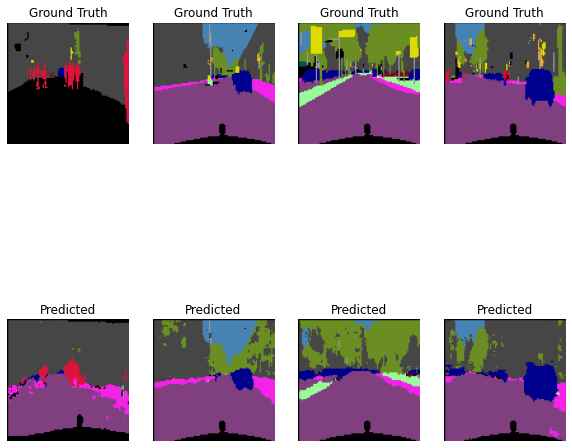

In [45]:
fig = plt.figure(figsize = (10,10))

for i in range(11,15):
  ax = fig.add_subplot(2, n_images, i-10)
  visualization = visual_label(mask[i,:,:].cpu().numpy(),labels_used)
  ax.imshow(visualization)
  ax.set_title('Ground Truth')
  ax.axis('off')

  ax = fig.add_subplot(2, n_images, i-6)
  y_test = y_pred.permute(0,2,3,1)[i,:,:,:].cpu().numpy()
  visual_test = visual_label(np.argmax(y_test,axis=2),labels_used)
  ax.imshow(visual_test)
  ax.set_title('Predicted')
  ax.axis('off')